<a href="https://colab.research.google.com/github/MLGroup28/financial_text_sentiment_analysis/blob/main/financial_text_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2025<br>
<font color=3C99D size=5>
      Financial Text Sentiment Analysis
</div>
<div dir=ltr align=center>
<font color=0CBCDF size=4>
    Faraz Doagooye Tehrani, Amir Parsa Safari, Hosna Shahheidari
<br>
<font color=0CBCDF size=4>
</div>

____

# PART ONE

---

In [3]:
from google.colab import drive
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
zip_path = '/content/drive/MyDrive/data/FinancialPhraseBank-v1.0.zip'
extract_path = '/content/financial_data/FinancialPhraseBank-v1.0/'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Files extracted successfully!")

data_file_allagree = extract_path + 'FinancialPhraseBank-v1.0/Sentences_AllAgree.txt'
df_allagree = pd.read_csv(data_file_allagree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')

print(f"Data ready! Total rows of all agree: {len(df_allagree)}")
df_allagree.head()

Files extracted successfully!
Data ready! Total rows of all agree: 2264


,sentence,label
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


In [6]:
data_file_75agree = extract_path + 'FinancialPhraseBank-v1.0/Sentences_75Agree.txt'
df_75agree = pd.read_csv(data_file_75agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')
data_file_66agree = extract_path + 'FinancialPhraseBank-v1.0/Sentences_66Agree.txt'
df_66agree = pd.read_csv(data_file_66agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')
data_file_50agree = extract_path + 'FinancialPhraseBank-v1.0/Sentences_50Agree.txt'
df_50agree = pd.read_csv(data_file_50agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')


set_all = set(df_allagree['sentence'])
set_75 = set(df_75agree['sentence'])
set_66 = set(df_66agree['sentence'])
set_50 = set(df_50agree['sentence'])

check_1 = set_all.issubset(set_75)
check_2 = set_75.issubset(set_66)
check_3 = set_66.issubset(set_50)

print(f"Is AllAgree inside 75Agree? {check_1}")
print(f"Is 75Agree inside 66Agree? {check_2}")
print(f"Is 66Agree inside 50Agree? {check_3}")

print(f"\nCounts:")
print(f"AllAgree: {len(set_all)}")
print(f"75Agree:  {len(set_75)}")
print(f"66Agree:  {len(set_66)}")
print(f"50Agree:  {len(set_50)}")

Is AllAgree inside 75Agree? True
Is 75Agree inside 66Agree? True
Is 66Agree inside 50Agree? True

Counts:
AllAgree: 2259
75Agree:  3448
66Agree:  4211
50Agree:  4838


<font color=3C99D size=5>
Conclusion: </font>

Since the set of 50 agree is the most general one we will train on that

In [7]:
df = df_50agree

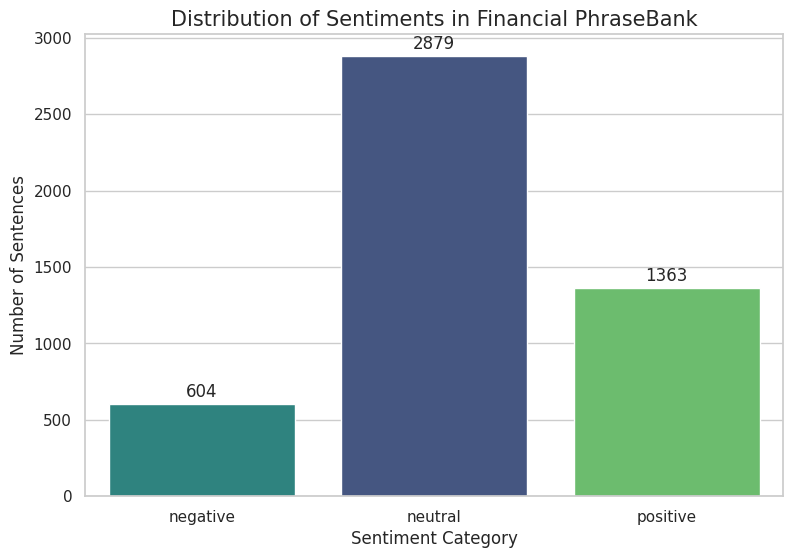

In [9]:
plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.countplot(x='label', data=df, palette='viridis', order=['negative', 'neutral', 'positive'], hue='label', legend=False)

plt.title('Distribution of Sentiments in Financial PhraseBank', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

In [8]:
label_encoder = LabelEncoder() #turning labels to numbers
df['label_idx'] = label_encoder.fit_transform(df['label'])

class_names = label_encoder.classes_
print(f"Mapping: {dict(zip(range(len(class_names)), class_names))}")

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_idx']
)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

Mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}
Train size: 3876, Validation size: 970


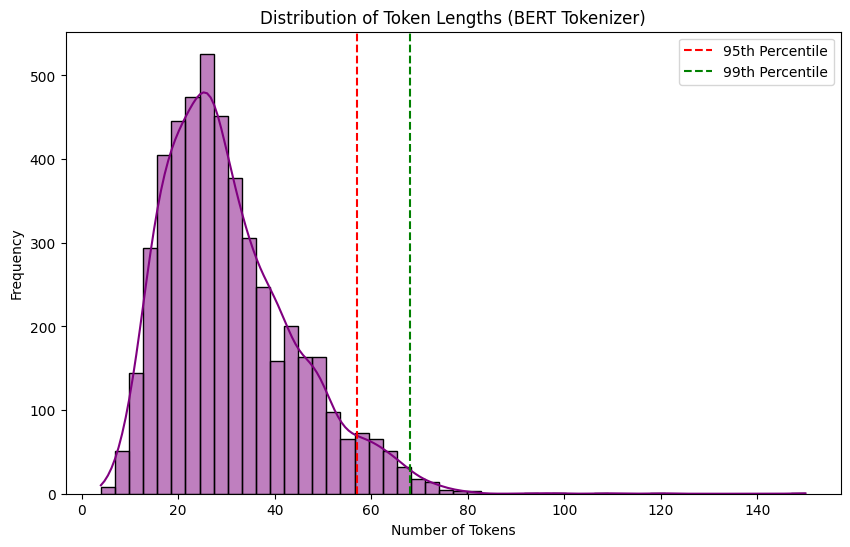

95% Percentile: 57.0
99% Percentile: 68.0
Max Length: 150


In [12]:
df['token_lengths'] = [len(tokenizer.encode(s, add_special_tokens=True)) for s in df['sentence']]

plt.figure(figsize=(10, 6))
sns.histplot(df['token_lengths'], bins=50, kde=True, color='purple')
plt.title('Distribution of Token Lengths (BERT Tokenizer)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

plt.axvline(x=df['token_lengths'].quantile(0.95), color='r', linestyle='--', label='95th Percentile')
plt.axvline(x=df['token_lengths'].quantile(0.99), color='g', linestyle='--', label='99th Percentile')
plt.legend()
plt.show()

print(f"95% Percentile: {df['token_lengths'].quantile(0.95)}")
print(f"99% Percentile: {df['token_lengths'].quantile(0.99)}")
print(f"Max Length: {df['token_lengths'].max()}")

<font color=3C99D size=5>
Conclusion: </font>

Since only less than one percent of the sentences have more than 68 tokens, choosing 80 tokens as the max length is a good number



In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class FinancialDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len=80):
        self.sentences = sentences.values
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = str(self.sentences[item])
        label = self.labels[item]

        encoding = self.tokenizer(
            sentence,
            add_special_tokens=True,  #Added [CLS], [SEP]
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



In [14]:
train_dataset = FinancialDataset(train_df['sentence'], train_df['label_idx'], tokenizer)
val_dataset = FinancialDataset(val_df['sentence'], val_df['label_idx'], tokenizer)

BATCH_SIZE = 16 #todo change to see the different results

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

sample_batch = next(iter(train_loader))
print(f"Input IDs shape: {sample_batch['input_ids'].shape}")
print(f"Attention Mask shape: {sample_batch['attention_mask'].shape}")

Input IDs shape: torch.Size([16, 80])
Attention Mask shape: torch.Size([16, 80])


# PART TWO

---